
Analyzing certificate chains in website_data...

Chain Structure Analysis:
Valid chains: 0
Invalid chains: 11950
Validity ratio: 0.00%


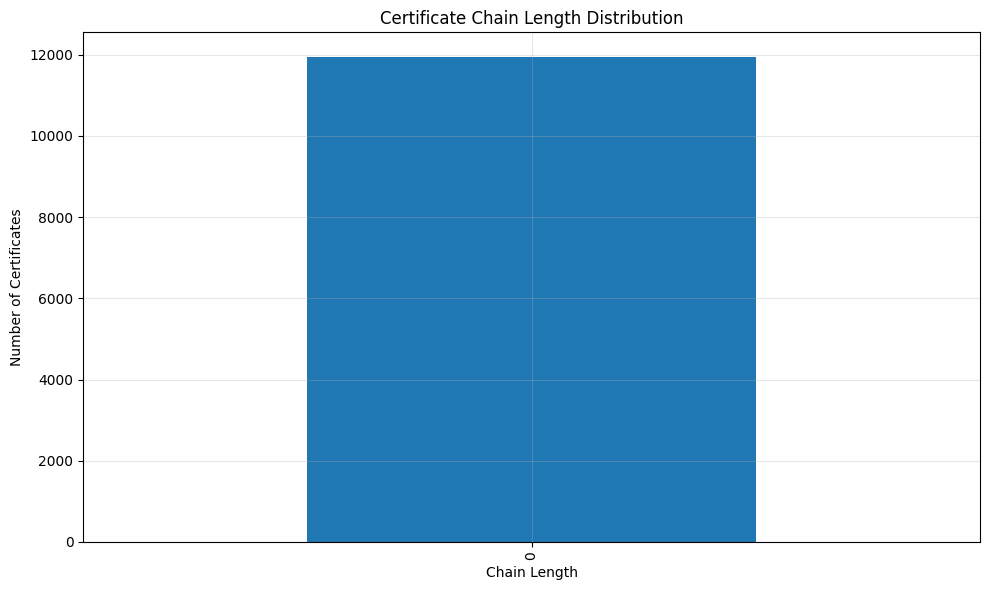

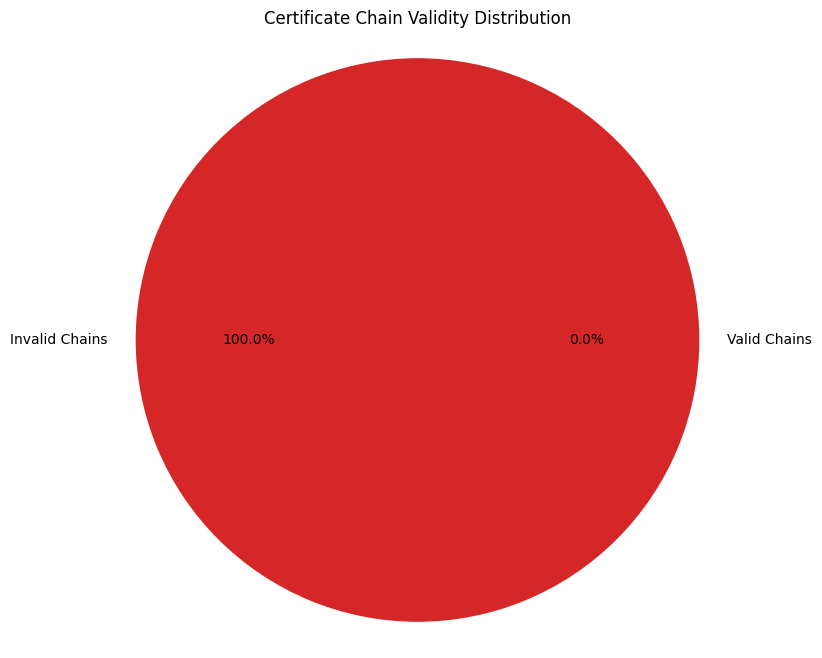


Intermediate Certificate Analysis:
Total intermediate certificates: 0
Unique intermediate issuers: 0


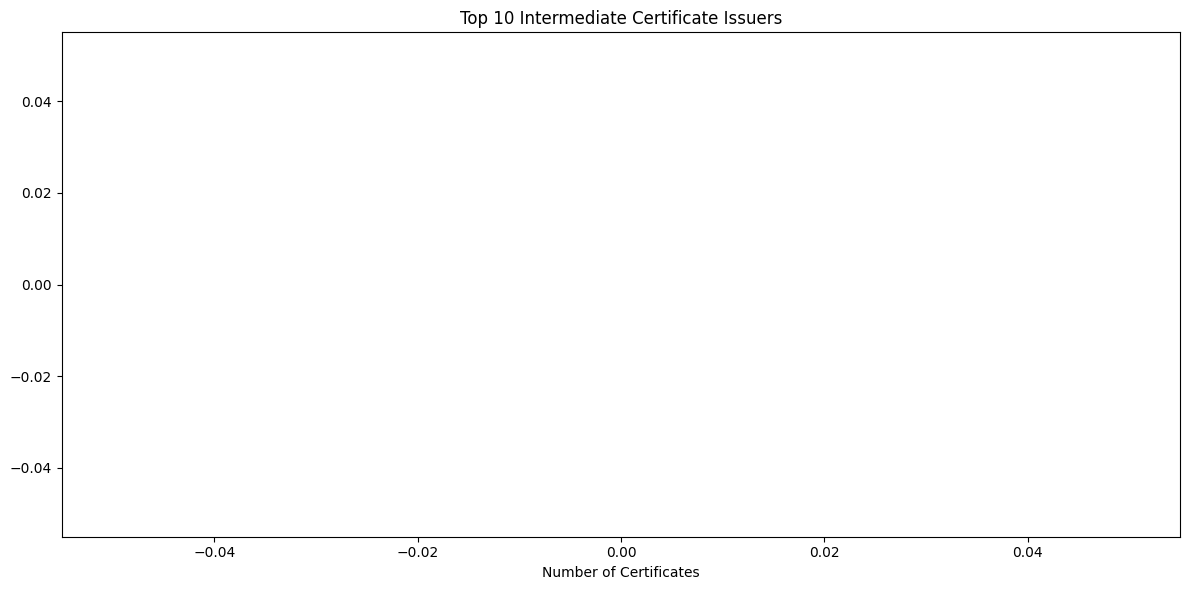


Analyzing certificate chains in normal_sites...

Chain Structure Analysis:
Valid chains: 0
Invalid chains: 9591
Validity ratio: 0.00%


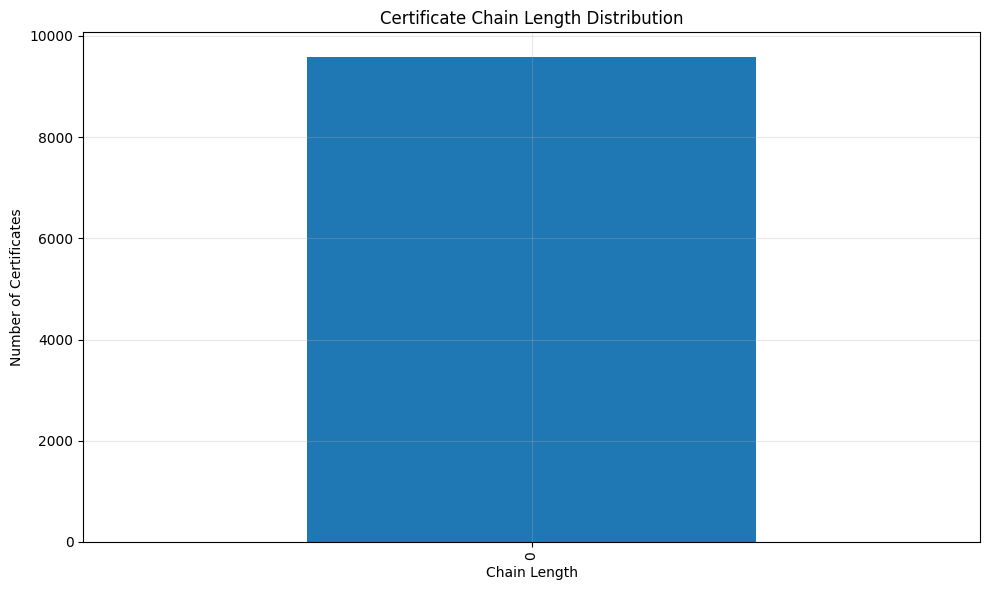

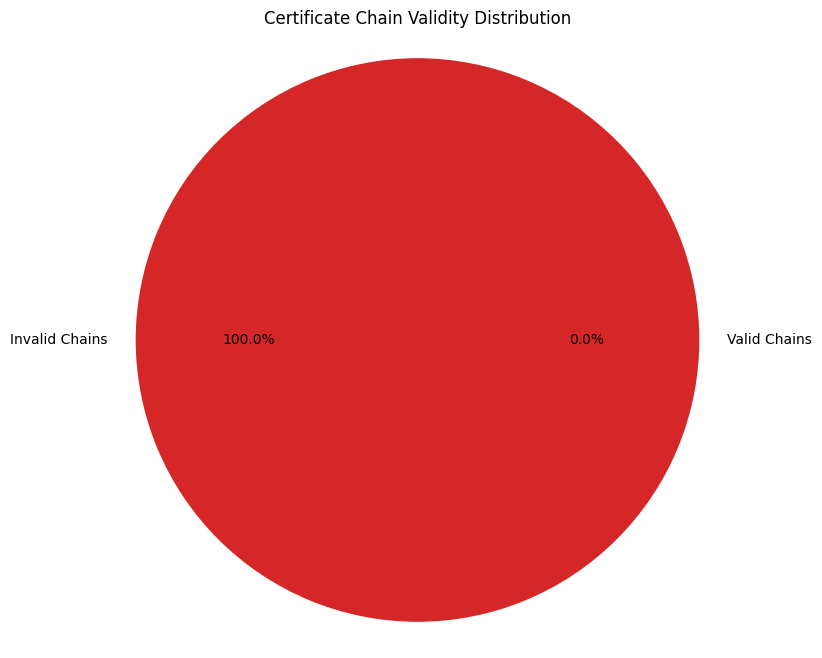


Intermediate Certificate Analysis:
Total intermediate certificates: 0
Unique intermediate issuers: 0


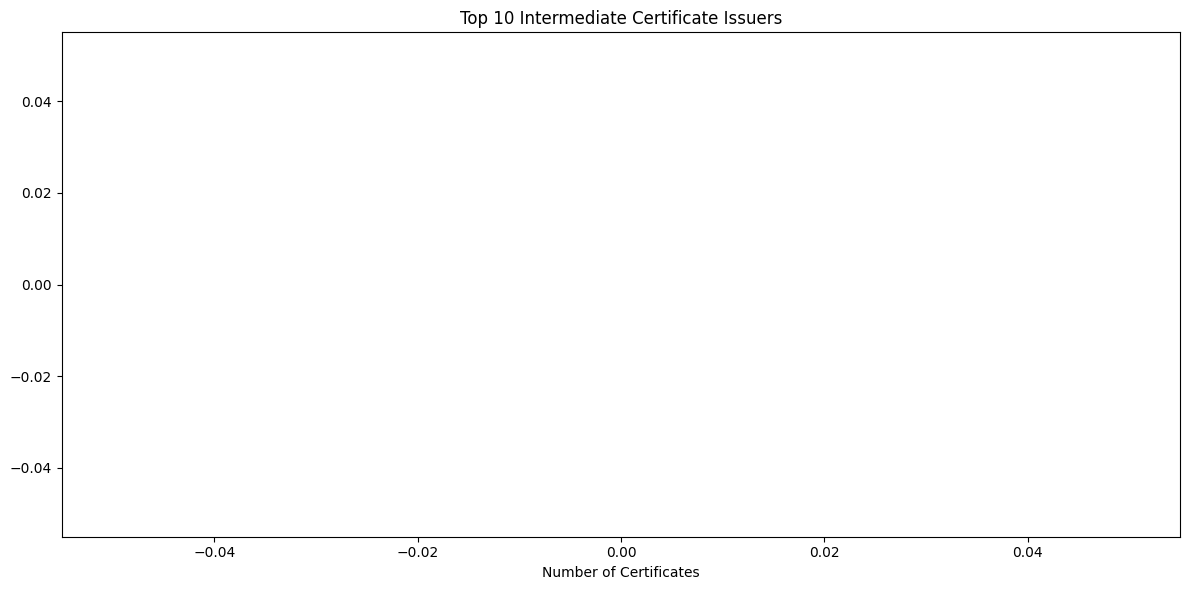

In [1]:
# 02_improved_certificate_chain_analyzer.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/02_improved_certificate_chain_analyzer.ipynb

"""
Improved Certificate Chain Analysis Program
This program provides enhanced analysis of SSL certificate chains with improved parsing
and validation logic.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
from pathlib import Path
import logging
from datetime import datetime
from typing import Dict, List, Optional, Tuple
import re

class ImprovedCertificateChainAnalyzer:
    """Enhanced analyzer for SSL certificate chains"""
    
    def __init__(self, config_path: str = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'):
        """Initialize the certificate chain analyzer"""
        self.setup_environment(config_path)
        self.setup_logging()
        self.setup_visualization()
        
    def setup_environment(self, config_path: str) -> None:
        """Setup analysis environment and load configuration"""
        with open(config_path) as f:
            self.config = json.load(f)['database']
            
        self.base_dir = Path('/home/asomura/waseda/nextstep/RAPIDS')
        self.output_dir = self.base_dir / 'reports' / 'chain_analysis'
        self.data_dir = self.base_dir / 'data' / 'processed'
        
        for dir_path in [self.output_dir, self.data_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
            
    def setup_logging(self) -> None:
        """Configure logging settings"""
        log_dir = self.base_dir / 'data' / 'logs'
        log_dir.mkdir(parents=True, exist_ok=True)
        
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        logging.basicConfig(
            filename=log_dir / f'improved_chain_analysis_{self.timestamp}.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def setup_visualization(self) -> None:
        """Setup visualization parameters"""
        plt.style.use('default')
        self.colors = {
            'primary': '#1f77b4',
            'secondary': '#ff7f0e',
            'accent': '#2ca02c',
            'error': '#d62728'
        }

    def get_database_engine(self, db_name: str) -> create_engine:
        """Create database connection engine"""
        host = 'localhost' if db_name == 'website_data' else 'localhost'
        return create_engine(
            f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
        )

    def extract_certificate_data(self, db_name: str) -> pd.DataFrame:
        """Extract certificate chain data from database"""
        self.logger.info(f"Extracting certificate data from {db_name}")
        
        query = """
        SELECT 
            domain,
            https_certificate_issuer,
            https_certificate_body,
            https_certificate_domain,
            https_certificate_all
        FROM website_data 
        WHERE status = 7 
        AND https_certificate_issuer IS NOT NULL
        """
        
        try:
            engine = self.get_database_engine(db_name)
            df = pd.read_sql_query(query, engine)
            self.logger.info(f"Successfully extracted {len(df)} records from {db_name}")
            return df
        except Exception as e:
            self.logger.error(f"Error extracting data from {db_name}: {str(e)}")
            raise

    def parse_certificate_chain(self, cert_data: str) -> List[Dict]:
        """
        Parse certificate chain data into structured format
        
        Args:
            cert_data: Raw certificate chain text
            
        Returns:
            List of dictionaries containing parsed certificate information
        """
        if pd.isna(cert_data):
            return []
            
        cert_data = str(cert_data)
        
        # Split into individual certificates
        certs = re.split(r'(?=-----BEGIN CERTIFICATE-----)', cert_data)
        parsed_certs = []
        
        for cert in certs:
            if '-----BEGIN CERTIFICATE-----' not in cert:
                continue
                
            cert_info = {}
            
            # Extract subject
            subject_match = re.search(r'Subject:\s*([^\n]+)', cert)
            if subject_match:
                cert_info['subject'] = subject_match.group(1).strip()
                
            # Extract issuer
            issuer_match = re.search(r'Issuer:\s*([^\n]+)', cert)
            if issuer_match:
                cert_info['issuer'] = issuer_match.group(1).strip()
                
            # Extract validity period
            validity_match = re.search(r'Not Before:\s*([^\n]+)\s*Not After\s*:\s*([^\n]+)', cert)
            if validity_match:
                cert_info['not_before'] = validity_match.group(1).strip()
                cert_info['not_after'] = validity_match.group(2).strip()
                
            if cert_info:
                parsed_certs.append(cert_info)
                
        return parsed_certs

    def analyze_chain_structure(self, df: pd.DataFrame) -> Dict:
        """
        Analyze certificate chain structure with improved validation
        
        Args:
            df: DataFrame containing certificate data
            
        Returns:
            Dictionary containing chain structure analysis results
        """
        def validate_chain(chain: List[Dict]) -> bool:
            if not chain or len(chain) < 2:
                return False
                
            # Check if each certificate is signed by the next one in chain
            for i in range(len(chain) - 1):
                if chain[i]['issuer'] != chain[i + 1]['subject']:
                    return False
            return True
            
        chain_structures = []
        valid_chains = 0
        total_chains = len(df)
        chain_lengths = []
        
        for _, row in df.iterrows():
            chain = self.parse_certificate_chain(row['https_certificate_all'])
            is_valid = validate_chain(chain)
            
            if is_valid:
                valid_chains += 1
            
            chain_structures.append({
                'length': len(chain),
                'valid': is_valid,
                'leaf_subject': chain[0]['subject'] if chain else None,
                'root_issuer': chain[-1]['issuer'] if chain else None
            })
            
            chain_lengths.append(len(chain))
            
        return {
            'valid_chains': valid_chains,
            'invalid_chains': total_chains - valid_chains,
            'validity_ratio': valid_chains / total_chains if total_chains > 0 else 0,
            'chain_lengths': chain_lengths,
            'structures': chain_structures
        }

    def analyze_intermediate_certificates(self, df: pd.DataFrame) -> Dict:
        """
        Analyze intermediate certificates in the chain
        
        Args:
            df: DataFrame containing certificate data
            
        Returns:
            Dictionary containing intermediate certificate analysis results
        """
        intermediate_issuers = []
        intermediate_subjects = []
        
        for _, row in df.iterrows():
            chain = self.parse_certificate_chain(row['https_certificate_all'])
            
            if len(chain) > 2:  # Only process chains with intermediates
                for cert in chain[1:-1]:  # Exclude leaf and root
                    intermediate_issuers.append(cert['issuer'])
                    intermediate_subjects.append(cert['subject'])
                    
        return {
            'total_intermediates': len(intermediate_issuers),
            'unique_issuers': len(set(intermediate_issuers)),
            'unique_subjects': len(set(intermediate_subjects)),
            'issuer_distribution': pd.Series(intermediate_issuers).value_counts().to_dict(),
            'subject_distribution': pd.Series(intermediate_subjects).value_counts().to_dict()
        }

    def plot_chain_analysis_results(self, structure_results: Dict) -> None:
        """
        Create visualizations for chain analysis results
        
        Args:
            structure_results: Dictionary containing chain structure analysis results
        """
        # Plot chain length distribution
        plt.figure(figsize=(10, 6))
        chain_lengths = pd.Series(structure_results['chain_lengths'])
        chain_lengths.value_counts().sort_index().plot(kind='bar')
        plt.title('Certificate Chain Length Distribution')
        plt.xlabel('Chain Length')
        plt.ylabel('Number of Certificates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot validity ratio
        plt.figure(figsize=(8, 8))
        labels = ['Valid Chains', 'Invalid Chains']
        sizes = [structure_results['valid_chains'], structure_results['invalid_chains']]
        colors = [self.colors['accent'], self.colors['error']]
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
        plt.title('Certificate Chain Validity Distribution')
        plt.axis('equal')
        plt.show()

    def plot_intermediate_distribution(self, intermediate_results: Dict) -> None:
        """
        Create visualizations for intermediate certificate analysis
        
        Args:
            intermediate_results: Dictionary containing intermediate certificate analysis results
        """
        # Plot top 10 intermediate issuers
        plt.figure(figsize=(12, 6))
        top_issuers = dict(sorted(
            intermediate_results['issuer_distribution'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:10])
        
        plt.barh(list(top_issuers.keys()), list(top_issuers.values()),
                color=self.colors['secondary'])
        plt.title('Top 10 Intermediate Certificate Issuers')
        plt.xlabel('Number of Certificates')
        plt.tight_layout()
        plt.show()

def main():
    """Main execution function"""
    analyzer = ImprovedCertificateChainAnalyzer()
    
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing certificate chains in {db_name}...")
        
        try:
            # Extract data
            df = analyzer.extract_certificate_data(db_name)
            
            # Analyze chain structure
            structure_results = analyzer.analyze_chain_structure(df)
            
            print("\nChain Structure Analysis:")
            print(f"Valid chains: {structure_results['valid_chains']}")
            print(f"Invalid chains: {structure_results['invalid_chains']}")
            print(f"Validity ratio: {structure_results['validity_ratio']:.2%}")
            
            # Plot chain analysis results
            analyzer.plot_chain_analysis_results(structure_results)
            
            # Analyze intermediate certificates
            intermediate_results = analyzer.analyze_intermediate_certificates(df)
            
            print("\nIntermediate Certificate Analysis:")
            print(f"Total intermediate certificates: {intermediate_results['total_intermediates']}")
            print(f"Unique intermediate issuers: {intermediate_results['unique_issuers']}")
            
            # Plot intermediate certificate distribution
            analyzer.plot_intermediate_distribution(intermediate_results)
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")
            logging.error(f"Error analyzing {db_name}: {str(e)}")

if __name__ == "__main__":
    main()


Analyzing website_data...

Certificate-related columns:
                             column_name          data_type  \
0                 https_certificate_date               date   
1                 https_certificate_body               text   
2               https_certificate_domain  character varying   
3               https_certificate_issuer  character varying   
4               https_certificate_expiry               text   
5           https_certificate_public_key               text   
6  https_certificate_signature_algorithm  character varying   
7           https_certificate_extensions               text   
8                  https_certificate_all               text   

   character_maximum_length  
0                       NaN  
1                       NaN  
2                     255.0  
3                     255.0  
4                       NaN  
5                       NaN  
6                     100.0  
7                       NaN  
8                       NaN  

Sample cert

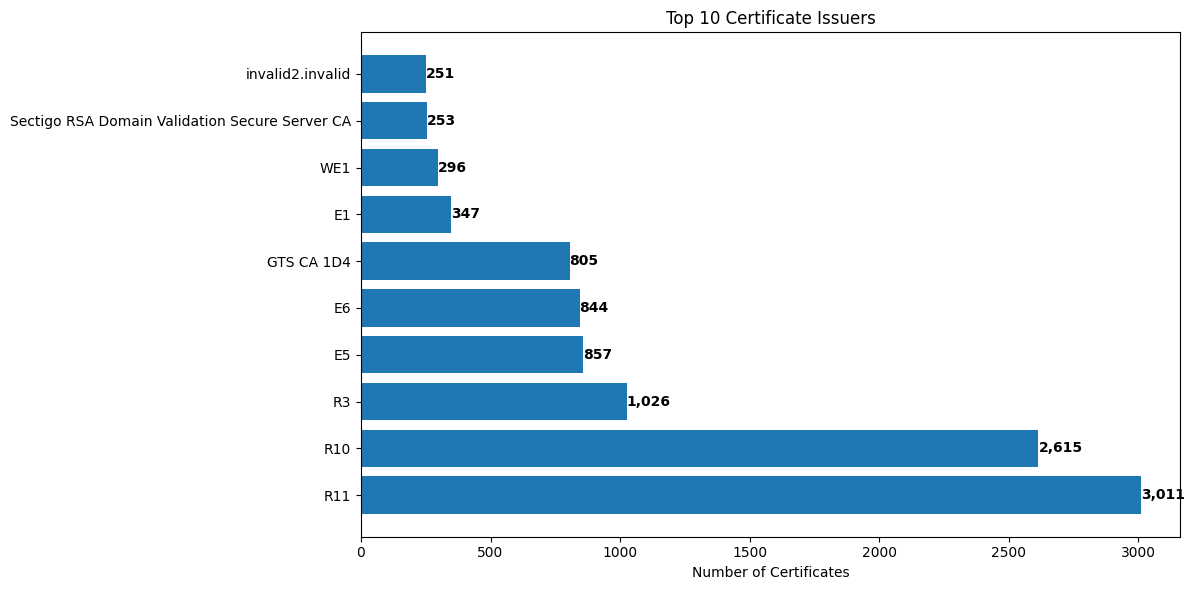


Top 10 certificate validity periods:
  https_certificate_expiry  count
0          20240619151514Z    797
1          20241211110310Z    477
2          20240723022221Z    335
3          20300101000000Z    251
4          20240730000325Z    232
5          20241230115252Z    184
6          20240826103216Z    158
7          20240819141254Z    144
8          20241217030225Z    124
9          20250314235959Z    113

Analyzing normal_sites...

Certificate-related columns:
                             column_name          data_type  \
0                 https_certificate_date               date   
1                 https_certificate_body               text   
2               https_certificate_domain  character varying   
3               https_certificate_issuer  character varying   
4               https_certificate_expiry               text   
5           https_certificate_public_key               text   
6  https_certificate_signature_algorithm  character varying   
7           https_certifica

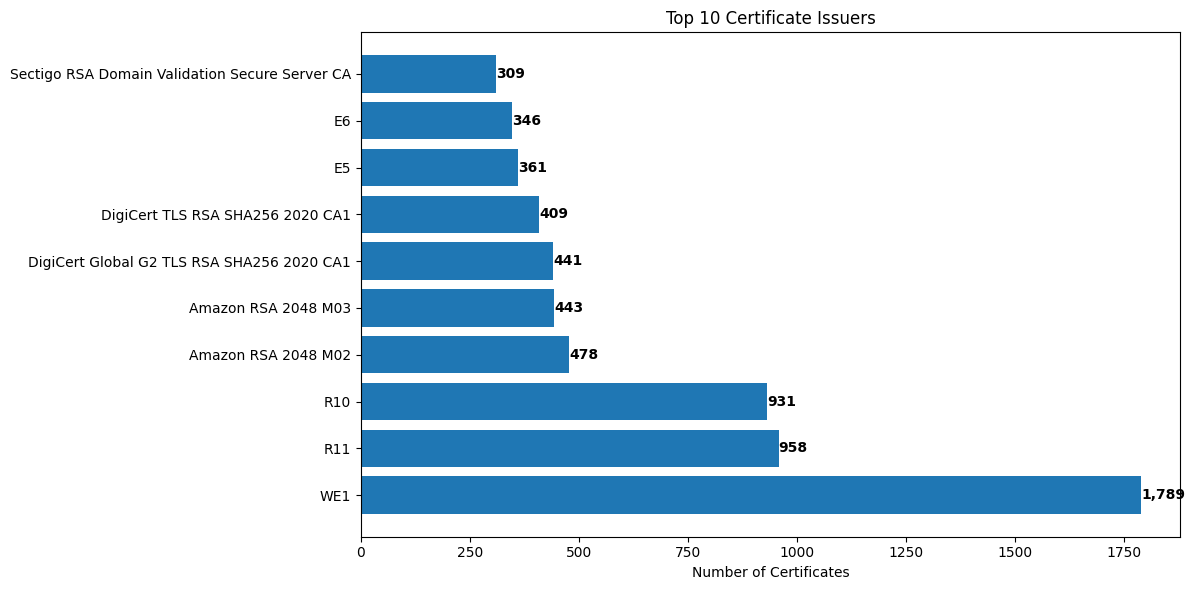


Top 10 certificate validity periods:
  https_certificate_expiry  count
0          20241231235959Z     70
1          20250423235959Z     62
2          20250322235959Z     37
3          20250807235959Z     36
4          20251017235959Z     32
5          20250103235959Z     30
6          20250730235959Z     29
7          20250910235959Z     28
8          20251112203814Z     24
9          20250701111950Z     23


In [2]:
# 04_fixed_certificate_chain_analyzer.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/04_fixed_certificate_chain_analyzer.ipynb

"""
Fixed Certificate Chain Analysis Program
This version includes corrected database connection handling and improved error management.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from pathlib import Path
import json
import logging
from datetime import datetime
import re

class FixedCertificateChainAnalyzer:
    """Analyzer for certificate data with fixed database connection"""
    
    def __init__(self, config_path: str = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'):
        """Initialize the analyzer"""
        self.setup_environment(config_path)
        self.setup_logging()
        self.setup_visualization()
        
    def setup_environment(self, config_path: str) -> None:
        """Setup analysis environment"""
        with open(config_path) as f:
            self.config = json.load(f)['database']
            
        self.base_dir = Path('/home/asomura/waseda/nextstep/RAPIDS')
        self.output_dir = self.base_dir / 'reports' / 'chain_analysis'
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
    def setup_logging(self) -> None:
        """Setup logging"""
        log_dir = self.base_dir / 'data' / 'logs'
        log_dir.mkdir(parents=True, exist_ok=True)
        
        logging.basicConfig(
            filename=log_dir / f'cert_analysis_{datetime.now():%Y%m%d}.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
    def setup_visualization(self) -> None:
        """Setup visualization parameters"""
        plt.style.use('default')
        self.colors = {
            'primary': '#1f77b4',
            'secondary': '#ff7f0e',
            'accent': '#2ca02c'
        }
        
    def get_database_engine(self, db_name: str) -> create_engine:
        """Create database engine with fixed parameters"""
        host = 'localhost' if db_name == 'website_data' else 'localhost'
        db_url = f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
        return create_engine(db_url)
        
    def inspect_certificate_data(self, db_name: str) -> None:
        """Inspect certificate data structure"""
        try:
            engine = self.get_database_engine(db_name)
            
            # Check column information using text()
            columns_query = text("""
                SELECT column_name, data_type, character_maximum_length
                FROM information_schema.columns
                WHERE table_name = 'website_data'
                AND column_name LIKE '%certificate%'
                ORDER BY ordinal_position;
            """)
            
            with engine.connect() as conn:
                columns_df = pd.read_sql_query(columns_query, conn)
                print("\nCertificate-related columns:")
                print(columns_df)
                
                # Get sample data
                sample_query = text("""
                    SELECT 
                        https_certificate_issuer,
                        https_certificate_domain,
                        https_certificate_body,
                        https_certificate_all
                    FROM website_data
                    WHERE status = 7
                    AND https_certificate_issuer IS NOT NULL
                    LIMIT 1;
                """)
                
                sample_df = pd.read_sql_query(sample_query, conn)
                print("\nSample certificate data:")
                for column in sample_df.columns:
                    print(f"\n{column}:")
                    value = sample_df[column].iloc[0]
                    if value is not None:
                        print(str(value)[:500] + "..." if len(str(value)) > 500 else value)
                    else:
                        print("NULL")
                
                # Get basic statistics
                stats_query = text("""
                    SELECT 
                        COUNT(*) as total_records,
                        COUNT(https_certificate_issuer) as records_with_issuer,
                        COUNT(https_certificate_domain) as records_with_domain,
                        COUNT(https_certificate_all) as records_with_chain
                    FROM website_data
                    WHERE status = 7;
                """)
                
                stats_df = pd.read_sql_query(stats_query, conn)
                print("\nBasic statistics:")
                print(stats_df)
                
        except Exception as e:
            self.logger.error(f"Error inspecting {db_name}: {str(e)}")
            print(f"Error inspecting {db_name}: {str(e)}")
            
    def analyze_certificate_issuers(self, db_name: str) -> None:
        """Analyze certificate issuers"""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT 
                    https_certificate_issuer,
                    COUNT(*) as count
                FROM website_data
                WHERE status = 7
                AND https_certificate_issuer IS NOT NULL
                GROUP BY https_certificate_issuer
                ORDER BY count DESC
                LIMIT 10;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                print("\nTop 10 certificate issuers:")
                print(df)
                
                # Create visualization
                plt.figure(figsize=(12, 6))
                bars = plt.barh(df['https_certificate_issuer'], df['count'],
                              color=self.colors['primary'])
                plt.title('Top 10 Certificate Issuers')
                plt.xlabel('Number of Certificates')
                
                # Add value labels on bars
                for bar in bars:
                    width = bar.get_width()
                    plt.text(width, bar.get_y() + bar.get_height()/2,
                            f'{int(width):,}',
                            ha='left', va='center', fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            self.logger.error(f"Error analyzing issuers in {db_name}: {str(e)}")
            print(f"Error analyzing issuers in {db_name}: {str(e)}")
            
    def analyze_certificate_validity(self, db_name: str) -> None:
        """Analyze certificate validity periods"""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT 
                    https_certificate_expiry,
                    COUNT(*) as count
                FROM website_data
                WHERE status = 7
                AND https_certificate_expiry IS NOT NULL
                GROUP BY https_certificate_expiry
                ORDER BY count DESC
                LIMIT 10;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                print("\nTop 10 certificate validity periods:")
                print(df)
                
                # Extract validity period from expiry text
                def extract_days(text):
                    if pd.isna(text):
                        return None
                    match = re.search(r'(\d+)\s*(?:days?|d)', str(text), re.IGNORECASE)
                    return int(match.group(1)) if match else None
                
                df['validity_days'] = df['https_certificate_expiry'].apply(extract_days)
                df = df.dropna(subset=['validity_days'])
                
                if not df.empty:
                    plt.figure(figsize=(10, 6))
                    plt.hist(df['validity_days'], bins=20, color=self.colors['secondary'])
                    plt.title('Certificate Validity Period Distribution')
                    plt.xlabel('Validity Period (days)')
                    plt.ylabel('Number of Certificates')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
                
        except Exception as e:
            self.logger.error(f"Error analyzing validity in {db_name}: {str(e)}")
            print(f"Error analyzing validity in {db_name}: {str(e)}")

def main():
    """Main execution function"""
    analyzer = FixedCertificateChainAnalyzer()
    
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing {db_name}...")
        
        try:
            # Inspect data structure
            analyzer.inspect_certificate_data(db_name)
            
            # Analyze certificate issuers
            analyzer.analyze_certificate_issuers(db_name)
            
            # Analyze validity periods
            analyzer.analyze_certificate_validity(db_name)
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")
            logging.error(f"Error analyzing {db_name}: {str(e)}")

if __name__ == "__main__":
    main()


Analyzing certificate chains in website_data...

Analyzing chain structure:

Protocol Distribution:
TLSv1.3    7708
TLSv1.2     252
Name: count, dtype: int64

Cipher Distribution:
TLS_AES_256_GCM_SHA384           7373
TLS_AES_128_GCM_SHA256            327
ECDHE-RSA-AES128-GCM-SHA256       191
ECDHE-RSA-AES256-GCM-SHA384        40
TLS_CHACHA20_POLY1305_SHA256        8
ECDHE-ECDSA-AES256-GCM-SHA384       6
ECDHE-ECDSA-CHACHA20-POLY1305       5
ECDHE-RSA-AES256-SHA384             4
ECDHE-RSA-CHACHA20-POLY1305         4
ECDHE-ECDSA-AES128-GCM-SHA256       1
AES128-GCM-SHA256                   1
Name: count, dtype: int64

Chain Length Distribution:
0     4112
3     7789
4       21
5       53
6       22
7       70
8        2
9        1
10       1
11       1
Name: count, dtype: int64


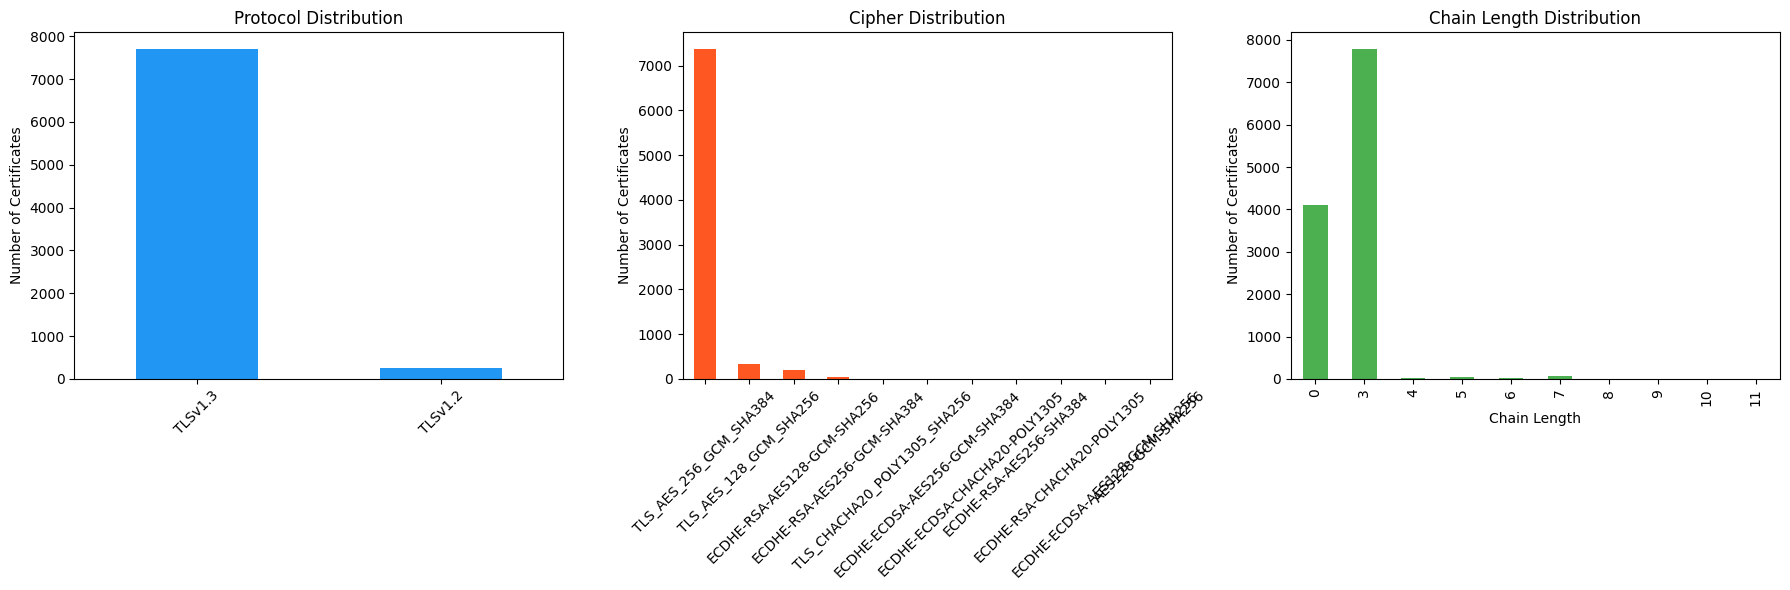


Analyzing intermediate certificates:

Analyzing certificate chains in normal_sites...

Analyzing chain structure:

Protocol Distribution:
TLSv1.3    8027
TLSv1.2    1564
Name: count, dtype: int64

Cipher Distribution:
TLS_AES_256_GCM_SHA384           5489
TLS_AES_128_GCM_SHA256           2501
ECDHE-RSA-AES128-GCM-SHA256       622
ECDHE-RSA-AES256-GCM-SHA384       512
ECDHE-RSA-CHACHA20-POLY1305       250
ECDHE-ECDSA-CHACHA20-POLY1305      49
ECDHE-ECDSA-AES256-GCM-SHA384      47
TLS_CHACHA20_POLY1305_SHA256       37
ECDHE-ECDSA-AES128-GCM-SHA256      30
ECDHE-RSA-AES256-SHA384            20
AES128-GCM-SHA256                   5
AES256-SHA                          5
DHE-RSA-AES256-GCM-SHA384           5
AES128-SHA                          5
AES256-SHA256                       5
ECDHE-RSA-AES256-SHA                3
ECDHE-RSA-AES128-SHA256             3
ECDHE-ECDSA-AES256-SHA384           1
DHE-RSA-AES128-GCM-SHA256           1
AES128-SHA256                       1
Name: count, dtype: i

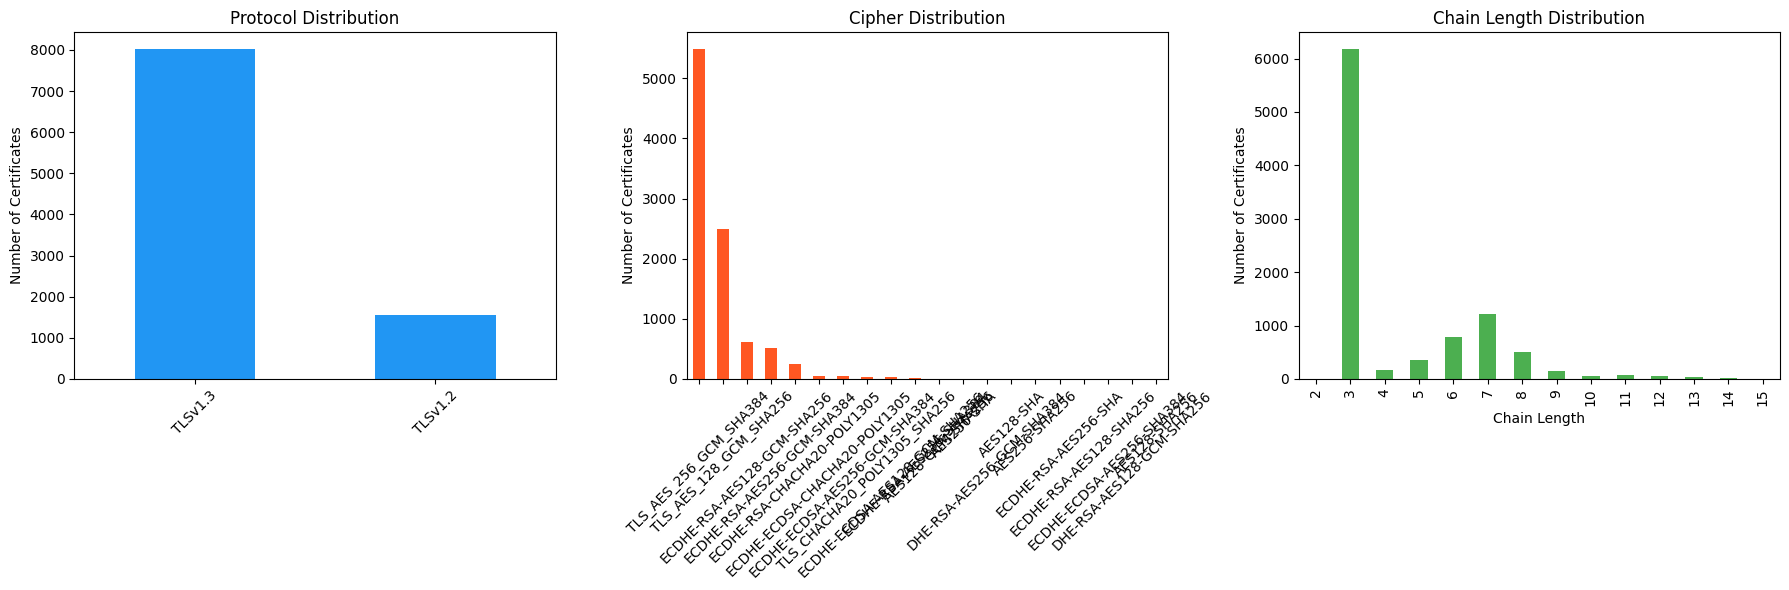


Analyzing intermediate certificates:


In [3]:
# 05_improved_chain_analyzer.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/05_improved_chain_analyzer.ipynb

"""
Improved Certificate Chain Analysis Program
This version includes detailed chain structure analysis and better parsing of certificate information.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from pathlib import Path
import json
import logging
from datetime import datetime
import re
from typing import Dict, List, Optional

class ImprovedChainAnalyzer:
    """Improved analyzer for certificate chains"""
    
    def __init__(self, config_path: str = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'):
        """Initialize the analyzer"""
        self.setup_environment(config_path)
        self.setup_logging()
        self.setup_visualization()
        
    def setup_environment(self, config_path: str) -> None:
        """Setup analysis environment"""
        with open(config_path) as f:
            self.config = json.load(f)['database']
            
        self.base_dir = Path('/home/asomura/waseda/nextstep/RAPIDS')
        self.output_dir = self.base_dir / 'reports' / 'chain_analysis'
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
    def setup_logging(self) -> None:
        """Setup logging"""
        log_dir = self.base_dir / 'data' / 'logs'
        log_dir.mkdir(parents=True, exist_ok=True)
        
        logging.basicConfig(
            filename=log_dir / f'chain_analysis_{datetime.now():%Y%m%d}.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
    def setup_visualization(self) -> None:
        """Setup visualization parameters"""
        plt.style.use('default')
        self.colors = {
            'primary': '#2196F3',
            'secondary': '#FF5722',
            'accent': '#4CAF50',
            'neutral': '#9E9E9E'
        }
        
    def get_database_engine(self, db_name: str) -> create_engine:
        """Create database engine"""
        host = 'localhost' if db_name == 'website_data' else 'localhost'
        return create_engine(
            f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
        )

    def parse_certificate_chain(self, chain_text: str) -> Dict:
        """
        Parse certificate chain text into structured format
        
        Args:
            chain_text: Raw certificate chain text
            
        Returns:
            Dictionary containing parsed chain information
        """
        if pd.isna(chain_text):
            return {
                'protocol': None,
                'cipher': None,
                'chain_length': 0,
                'certificates': []
            }
            
        chain_info = {
            'protocol': None,
            'cipher': None,
            'chain_length': 0,
            'certificates': []
        }
        
        # Extract protocol and cipher
        protocol_match = re.search(r'Protocol: (.*?)(?:\n|$)', chain_text)
        cipher_match = re.search(r'Cipher: (.*?)(?:\n|$)', chain_text)
        
        if protocol_match:
            chain_info['protocol'] = protocol_match.group(1).strip()
        if cipher_match:
            chain_info['cipher'] = cipher_match.group(1).strip()
            
        # Extract certificates from chain
        cert_pattern = r'\s*(\d+)\s+s:(.*?)(?=\s*\d+\s+s:|\s*$)'
        certificates = re.findall(cert_pattern, chain_text)
        
        for index, cert_info in certificates:
            fields = cert_info.split(',')
            cert_dict = {}
            
            for field in fields:
                if '=' in field:
                    key, value = field.split('=', 1)
                    cert_dict[key.strip()] = value.strip()
                    
            chain_info['certificates'].append({
                'index': int(index),
                'fields': cert_dict
            })
            
        chain_info['chain_length'] = len(chain_info['certificates'])
        
        return chain_info

    def analyze_chain_structure(self, db_name: str) -> None:
        """Analyze certificate chain structure"""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT https_certificate_all
                FROM website_data
                WHERE status = 7
                AND https_certificate_all IS NOT NULL;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                # Parse all chains
                chain_data = df['https_certificate_all'].apply(self.parse_certificate_chain)
                
                # Analyze protocols
                protocols = [chain['protocol'] for chain in chain_data if chain['protocol']]
                protocol_dist = pd.Series(protocols).value_counts()
                
                # Analyze ciphers
                ciphers = [chain['cipher'] for chain in chain_data if chain['cipher']]
                cipher_dist = pd.Series(ciphers).value_counts()
                
                # Analyze chain lengths
                chain_lengths = [chain['chain_length'] for chain in chain_data]
                length_dist = pd.Series(chain_lengths).value_counts().sort_index()
                
                # Print results
                print("\nProtocol Distribution:")
                print(protocol_dist)
                
                print("\nCipher Distribution:")
                print(cipher_dist)
                
                print("\nChain Length Distribution:")
                print(length_dist)
                
                # Visualize results
                self.plot_chain_analysis(protocol_dist, cipher_dist, length_dist)
                
        except Exception as e:
            self.logger.error(f"Error analyzing chain structure: {str(e)}")
            print(f"Error: {str(e)}")

    def plot_chain_analysis(self, protocol_dist: pd.Series, cipher_dist: pd.Series, 
                          length_dist: pd.Series) -> None:
        """Create visualizations for chain analysis"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Protocol distribution
        protocol_dist.plot(kind='bar', ax=ax1, color=self.colors['primary'])
        ax1.set_title('Protocol Distribution')
        ax1.set_ylabel('Number of Certificates')
        ax1.tick_params(axis='x', rotation=45)
        
        # Cipher distribution
        cipher_dist.plot(kind='bar', ax=ax2, color=self.colors['secondary'])
        ax2.set_title('Cipher Distribution')
        ax2.set_ylabel('Number of Certificates')
        ax2.tick_params(axis='x', rotation=45)
        
        # Chain length distribution
        length_dist.plot(kind='bar', ax=ax3, color=self.colors['accent'])
        ax3.set_title('Chain Length Distribution')
        ax3.set_xlabel('Chain Length')
        ax3.set_ylabel('Number of Certificates')
        
        plt.tight_layout()
        plt.show()

    def analyze_intermediate_certificates(self, db_name: str) -> None:
        """Analyze intermediate certificates in the chain"""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT https_certificate_all
                FROM website_data
                WHERE status = 7
                AND https_certificate_all IS NOT NULL;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                # Parse chains and extract intermediate certificates
                chain_data = df['https_certificate_all'].apply(self.parse_certificate_chain)
                
                intermediate_certs = []
                for chain in chain_data:
                    certs = chain['certificates']
                    if len(certs) > 2:  # If there are intermediate certificates
                        for cert in certs[1:-1]:  # Exclude leaf and root
                            if cert.get('fields'):
                                intermediate_certs.append(cert['fields'])
                
                # Analyze intermediate certificates
                if intermediate_certs:
                    # Count unique intermediate issuers
                    if 'organizationName' in intermediate_certs[0]:
                        orgs = [cert.get('organizationName') for cert in intermediate_certs]
                        org_dist = pd.Series(orgs).value_counts()
                        
                        print("\nIntermediate Certificate Organizations:")
                        print(org_dist)
                        
                        # Visualize organization distribution
                        plt.figure(figsize=(12, 6))
                        org_dist.head(10).plot(kind='bar', color=self.colors['primary'])
                        plt.title('Top 10 Intermediate Certificate Organizations')
                        plt.xlabel('Organization')
                        plt.ylabel('Number of Certificates')
                        plt.xticks(rotation=45, ha='right')
                        plt.tight_layout()
                        plt.show()
                
                else:
                    print("\nNo intermediate certificates found in the chains")
                
        except Exception as e:
            self.logger.error(f"Error analyzing intermediate certificates: {str(e)}")
            print(f"Error: {str(e)}")

def main():
    """Main execution function"""
    analyzer = ImprovedChainAnalyzer()
    
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing certificate chains in {db_name}...")
        
        try:
            # Analyze chain structure
            print("\nAnalyzing chain structure:")
            analyzer.analyze_chain_structure(db_name)
            
            # Analyze intermediate certificates
            print("\nAnalyzing intermediate certificates:")
            analyzer.analyze_intermediate_certificates(db_name)
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")
            logging.error(f"Error analyzing {db_name}: {str(e)}")

if __name__ == "__main__":
    main()


Analyzing certificate chains in website_data...

Analyzing chain structure:

Protocol Distribution:
TLSv1.3    7710
TLSv1.2     252
Name: count, dtype: int64

Cipher Distribution:
TLS_AES_256_GCM_SHA384           7375
TLS_AES_128_GCM_SHA256            327
ECDHE-RSA-AES128-GCM-SHA256       191
ECDHE-RSA-AES256-GCM-SHA384        40
TLS_CHACHA20_POLY1305_SHA256        8
ECDHE-ECDSA-AES256-GCM-SHA384       6
ECDHE-ECDSA-CHACHA20-POLY1305       5
ECDHE-RSA-AES256-SHA384             4
ECDHE-RSA-CHACHA20-POLY1305         4
ECDHE-ECDSA-AES128-GCM-SHA256       1
AES128-GCM-SHA256                   1
Name: count, dtype: int64

Chain Length Distribution:
1       15
2     2082
3     1558
4     8247
5       22
6       53
7       22
8       70
9        2
10       1
11       1
12       1
Name: count, dtype: int64


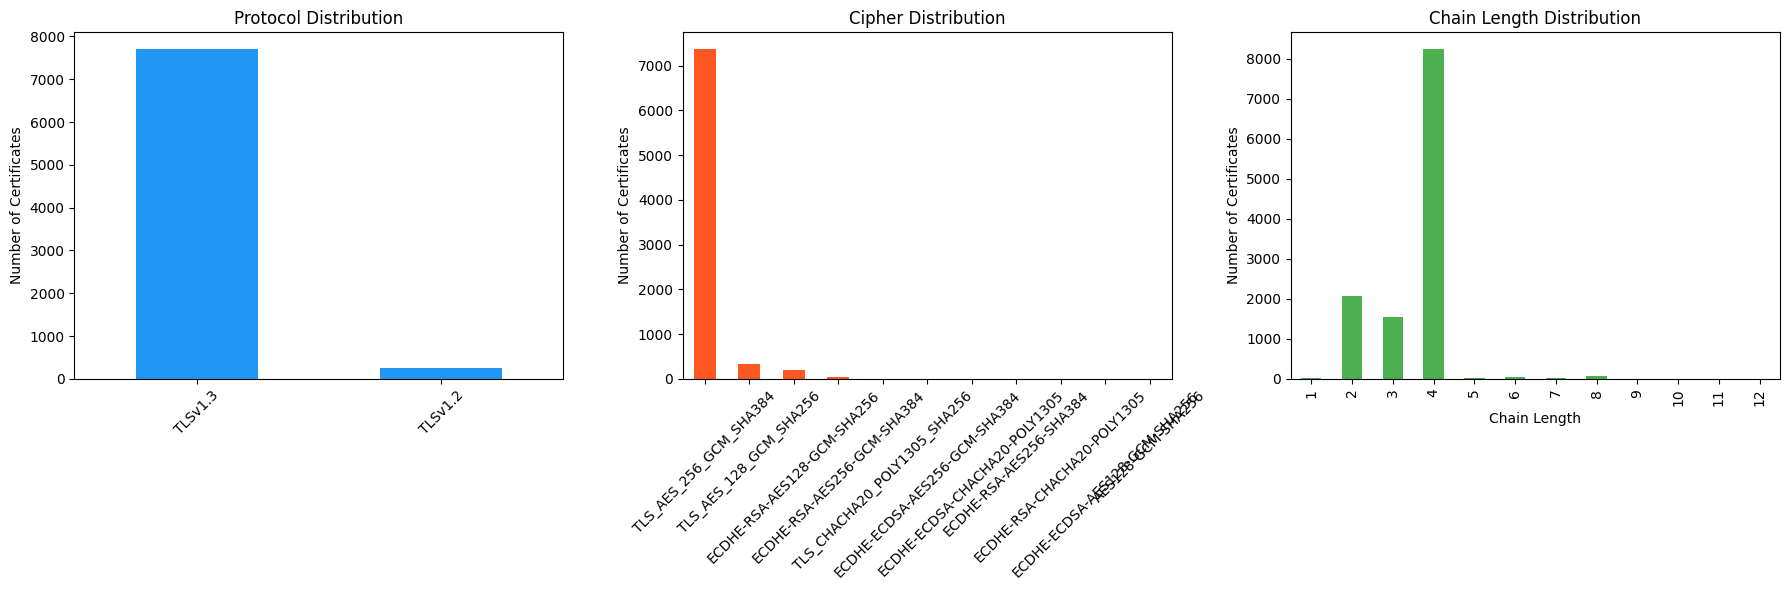


Analyzing intermediate certificates:

Analyzing certificate chains in normal_sites...

Analyzing chain structure:

Protocol Distribution:
TLSv1.3    8027
TLSv1.2    1564
Name: count, dtype: int64

Cipher Distribution:
TLS_AES_256_GCM_SHA384           5489
TLS_AES_128_GCM_SHA256           2501
ECDHE-RSA-AES128-GCM-SHA256       622
ECDHE-RSA-AES256-GCM-SHA384       512
ECDHE-RSA-CHACHA20-POLY1305       250
ECDHE-ECDSA-CHACHA20-POLY1305      49
ECDHE-ECDSA-AES256-GCM-SHA384      47
TLS_CHACHA20_POLY1305_SHA256       37
ECDHE-ECDSA-AES128-GCM-SHA256      30
ECDHE-RSA-AES256-SHA384            20
AES128-GCM-SHA256                   5
AES256-SHA                          5
DHE-RSA-AES256-GCM-SHA384           5
AES128-SHA                          5
AES256-SHA256                       5
ECDHE-RSA-AES256-SHA                3
ECDHE-RSA-AES128-SHA256             3
ECDHE-ECDSA-AES256-SHA384           1
DHE-RSA-AES128-GCM-SHA256           1
AES128-SHA256                       1
Name: count, dtype: i

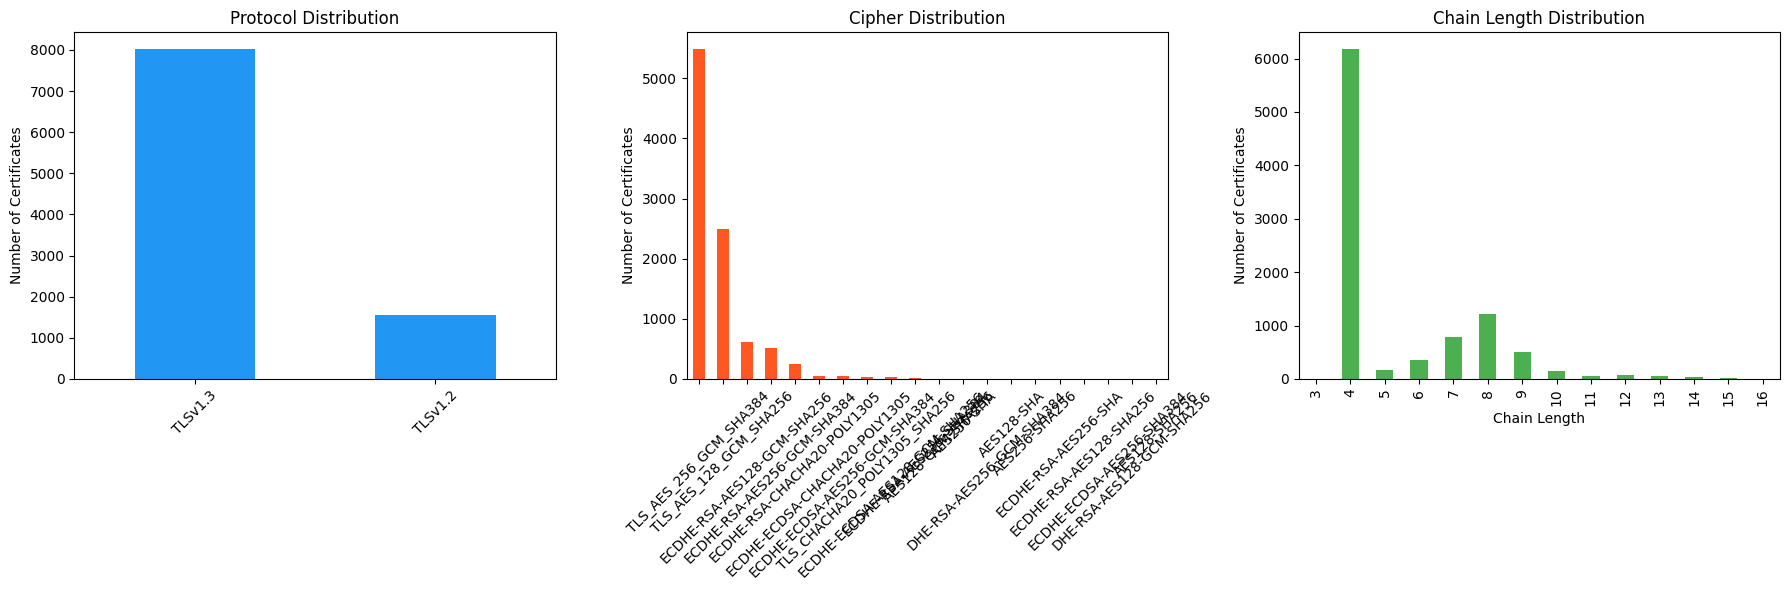


Analyzing intermediate certificates:

CSV export for distribution comparisons completed.


In [1]:
"""
Improved Certificate Chain Analysis Program with CSV Export Functionality
- 証明書チェーンの解析、可視化に加えて、website_dataとnormal_sitesの各統計を比較するCSV出力機能を実装。
- 改善点として、正規表現のコンパイル、設定ファイルの外部化、エラーハンドリングの強化を行っています。
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from pathlib import Path
import json
import logging
from datetime import datetime
import re
from typing import Dict

class ImprovedChainAnalyzer:
    """Improved analyzer for certificate chains with CSV export functionality."""
    
    def __init__(self, config_path: str = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'):
        """Initialize the analyzer with environment, logging, visualization, and precompiled regex patterns."""
        self.setup_environment(config_path)
        self.setup_logging()
        self.setup_visualization()
        self.compile_regex_patterns()
        
    def compile_regex_patterns(self) -> None:
        """Precompile regex patterns for performance optimization."""
        self.protocol_pattern = re.compile(r'Protocol: (.*?)(?:\n|$)')
        self.cipher_pattern = re.compile(r'Cipher: (.*?)(?:\n|$)')
        self.cert_pattern = re.compile(r'\s*(\d+)\s+s:(.*?)(?=\s*\d+\s+s:|\s*$)', re.DOTALL)
    
    def setup_environment(self, config_path: str) -> None:
        """Setup analysis environment, including configuration and output directories."""
        try:
            with open(config_path) as f:
                self.config = json.load(f)['database']
        except Exception as e:
            raise RuntimeError(f"Failed to load configuration file: {str(e)}")
            
        self.base_dir = Path('/home/asomura/waseda/nextstep/RAPIDS')
        self.output_dir = self.base_dir / 'reports' / 'chain_analysis'
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
    def setup_logging(self) -> None:
        """Setup logging configuration."""
        log_dir = self.base_dir / 'data' / 'logs'
        log_dir.mkdir(parents=True, exist_ok=True)
        
        logging.basicConfig(
            filename=log_dir / f'chain_analysis_{datetime.now():%Y%m%d}.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
    def setup_visualization(self) -> None:
        """Setup visualization parameters."""
        plt.style.use('default')
        self.colors = {
            'primary': '#2196F3',
            'secondary': '#FF5722',
            'accent': '#4CAF50',
            'neutral': '#9E9E9E'
        }
        
    def get_database_engine(self, db_name: str):
        """Create and return a SQLAlchemy database engine."""
        host = 'localhost'  # ホストは必要に応じて外部設定可能
        try:
            engine = create_engine(
                f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
            )
            return engine
        except Exception as e:
            self.logger.error(f"Database engine creation failed for {db_name}: {str(e)}")
            raise

    def parse_certificate_chain(self, chain_text: str) -> Dict:
        """
        Parse certificate chain text into a structured format.
        
        Args:
            chain_text: Raw certificate chain text.
            
        Returns:
            Dictionary containing parsed chain information.
        """
        if pd.isna(chain_text):
            return {
                'protocol': None,
                'cipher': None,
                'chain_length': 0,
                'certificates': []
            }
            
        chain_info = {
            'protocol': None,
            'cipher': None,
            'chain_length': 0,
            'certificates': []
        }
        
        try:
            protocol_match = self.protocol_pattern.search(chain_text)
            cipher_match = self.cipher_pattern.search(chain_text)
            
            if protocol_match:
                chain_info['protocol'] = protocol_match.group(1).strip()
            if cipher_match:
                chain_info['cipher'] = cipher_match.group(1).strip()
                
            certificates = self.cert_pattern.findall(chain_text)
            
            for index, cert_info in certificates:
                fields = cert_info.split(',')
                cert_dict = {}
                for field in fields:
                    if '=' in field:
                        key, value = field.split('=', 1)
                        cert_dict[key.strip()] = value.strip()
                chain_info['certificates'].append({
                    'index': int(index),
                    'fields': cert_dict
                })
                
            chain_info['chain_length'] = len(chain_info['certificates'])
        except Exception as e:
            self.logger.error(f"Error parsing certificate chain: {str(e)}")
        
        return chain_info

    def get_distributions(self, db_name: str) -> Dict[str, pd.DataFrame]:
        """
        Retrieve and compute distributions for protocol, cipher, and chain length from the specified database.
        
        Args:
            db_name: The database name to query.
            
        Returns:
            Dictionary with keys 'protocol', 'cipher', 'chain_length' containing corresponding DataFrames.
        """
        engine = self.get_database_engine(db_name)
        query = text("""
            SELECT https_certificate_all
            FROM website_data
            WHERE status = 7
            AND https_certificate_all IS NOT NULL;
        """)
        try:
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
        except Exception as e:
            self.logger.error(f"Error querying database {db_name}: {str(e)}")
            raise
        
        chain_data = df['https_certificate_all'].apply(self.parse_certificate_chain)
        
        # プロトコル分布の計算
        protocols = [chain['protocol'] for chain in chain_data if chain['protocol']]
        protocol_series = pd.Series(protocols)
        protocol_count = protocol_series.value_counts().sort_index()
        protocol_df = protocol_count.reset_index()
        protocol_df.columns = ['プロトコル', 'count']
        total_protocols = protocol_series.shape[0]
        protocol_df['percentage'] = protocol_df['count'] / total_protocols * 100
        
        # 暗号分布の計算
        ciphers = [chain['cipher'] for chain in chain_data if chain['cipher']]
        cipher_series = pd.Series(ciphers)
        cipher_count = cipher_series.value_counts().sort_index()
        cipher_df = cipher_count.reset_index()
        cipher_df.columns = ['暗号の種類', 'count']
        total_ciphers = cipher_series.shape[0]
        cipher_df['percentage'] = cipher_df['count'] / total_ciphers * 100
        
        # チェーン長分布の計算
        chain_lengths = [chain['chain_length'] for chain in chain_data]
        length_series = pd.Series(chain_lengths)
        length_count = length_series.value_counts().sort_index()
        length_df = length_count.reset_index()
        length_df.columns = ['Chain Length', 'count']
        total_lengths = length_series.shape[0]
        length_df['percentage'] = length_df['count'] / total_lengths * 100
        
        return {
            'protocol': protocol_df,
            'cipher': cipher_df,
            'chain_length': length_df
        }
        
    def export_comparison_csv(self) -> None:
        """
        Export CSV files comparing distributions (protocol, cipher, chain length)
        between 'website_data' and 'normal_sites' databases.
        出力ファイルはreports/chain_analysisディレクトリに保存される。
        """
        distributions = {}
        for db in ['website_data', 'normal_sites']:
            try:
                distributions[db] = self.get_distributions(db)
            except Exception as e:
                self.logger.error(f"Failed to get distributions for {db}: {str(e)}")
                continue
        
        # プロトコル分布のCSV出力
        if 'website_data' in distributions and 'protocol' in distributions['website_data'] and \
           'normal_sites' in distributions:
            website_protocol = distributions['website_data']['protocol'].set_index('プロトコル')
            normal_protocol = distributions['normal_sites']['protocol'].set_index('プロトコル')
            protocol_compare = website_protocol.join(
                normal_protocol, how='outer', lsuffix='_website_data', rsuffix='_normal_sites'
            ).fillna(0).reset_index()
            protocol_csv_path = self.output_dir / 'protocol_distribution_comparison.csv'
            protocol_compare.to_csv(protocol_csv_path, index=False, encoding='utf-8-sig')
            self.logger.info(f"Exported Protocol Distribution CSV to {protocol_csv_path}")
        
        # 暗号分布のCSV出力
        if 'website_data' in distributions and 'cipher' in distributions['website_data'] and \
           'normal_sites' in distributions:
            website_cipher = distributions['website_data']['cipher'].set_index('暗号の種類')
            normal_cipher = distributions['normal_sites']['cipher'].set_index('暗号の種類')
            cipher_compare = website_cipher.join(
                normal_cipher, how='outer', lsuffix='_website_data', rsuffix='_normal_sites'
            ).fillna(0).reset_index()
            cipher_csv_path = self.output_dir / 'cipher_distribution_comparison.csv'
            cipher_compare.to_csv(cipher_csv_path, index=False, encoding='utf-8-sig')
            self.logger.info(f"Exported Cipher Distribution CSV to {cipher_csv_path}")
        
        # チェーン長分布のCSV出力
        if 'website_data' in distributions and 'chain_length' in distributions['website_data'] and \
           'normal_sites' in distributions:
            website_length = distributions['website_data']['chain_length'].set_index('Chain Length')
            normal_length = distributions['normal_sites']['chain_length'].set_index('Chain Length')
            length_compare = website_length.join(
                normal_length, how='outer', lsuffix='_website_data', rsuffix='_normal_sites'
            ).fillna(0).reset_index()
            length_csv_path = self.output_dir / 'chain_length_distribution_comparison.csv'
            length_compare.to_csv(length_csv_path, index=False, encoding='utf-8-sig')
            self.logger.info(f"Exported Chain Length Distribution CSV to {length_csv_path}")
        
    def analyze_chain_structure(self, db_name: str) -> None:
        """Analyze certificate chain structure and visualize distributions."""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT https_certificate_all
                FROM website_data
                WHERE status = 7
                AND https_certificate_all IS NOT NULL;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                chain_data = df['https_certificate_all'].apply(self.parse_certificate_chain)
                
                protocols = [chain['protocol'] for chain in chain_data if chain['protocol']]
                protocol_dist = pd.Series(protocols).value_counts()
                
                ciphers = [chain['cipher'] for chain in chain_data if chain['cipher']]
                cipher_dist = pd.Series(ciphers).value_counts()
                
                chain_lengths = [chain['chain_length'] for chain in chain_data]
                length_dist = pd.Series(chain_lengths).value_counts().sort_index()
                
                print("\nProtocol Distribution:")
                print(protocol_dist)
                
                print("\nCipher Distribution:")
                print(cipher_dist)
                
                print("\nChain Length Distribution:")
                print(length_dist)
                
                self.plot_chain_analysis(protocol_dist, cipher_dist, length_dist)
                
        except Exception as e:
            self.logger.error(f"Error analyzing chain structure: {str(e)}")
            print(f"Error: {str(e)}")

    def plot_chain_analysis(self, protocol_dist: pd.Series, cipher_dist: pd.Series, 
                            length_dist: pd.Series) -> None:
        """Visualize distributions for certificate chain analysis."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        protocol_dist.plot(kind='bar', ax=ax1, color=self.colors['primary'])
        ax1.set_title('Protocol Distribution')
        ax1.set_ylabel('Number of Certificates')
        ax1.tick_params(axis='x', rotation=45)
        
        cipher_dist.plot(kind='bar', ax=ax2, color=self.colors['secondary'])
        ax2.set_title('Cipher Distribution')
        ax2.set_ylabel('Number of Certificates')
        ax2.tick_params(axis='x', rotation=45)
        
        length_dist.plot(kind='bar', ax=ax3, color=self.colors['accent'])
        ax3.set_title('Chain Length Distribution')
        ax3.set_xlabel('Chain Length')
        ax3.set_ylabel('Number of Certificates')
        
        plt.tight_layout()
        plt.show()

    def analyze_intermediate_certificates(self, db_name: str) -> None:
        """Analyze intermediate certificates in the chain and visualize issuer distribution."""
        try:
            engine = self.get_database_engine(db_name)
            
            query = text("""
                SELECT https_certificate_all
                FROM website_data
                WHERE status = 7
                AND https_certificate_all IS NOT NULL;
            """)
            
            with engine.connect() as conn:
                df = pd.read_sql_query(query, conn)
                
                chain_data = df['https_certificate_all'].apply(self.parse_certificate_chain)
                
                intermediate_certs = []
                for chain in chain_data:
                    certs = chain['certificates']
                    if len(certs) > 2:
                        for cert in certs[1:-1]:
                            if cert.get('fields'):
                                intermediate_certs.append(cert['fields'])
                
                if intermediate_certs:
                    if 'organizationName' in intermediate_certs[0]:
                        orgs = [cert.get('organizationName') for cert in intermediate_certs]
                        org_dist = pd.Series(orgs).value_counts()
                        
                        print("\nIntermediate Certificate Organizations:")
                        print(org_dist)
                        
                        plt.figure(figsize=(12, 6))
                        org_dist.head(10).plot(kind='bar', color=self.colors['primary'])
                        plt.title('Top 10 Intermediate Certificate Organizations')
                        plt.xlabel('Organization')
                        plt.ylabel('Number of Certificates')
                        plt.xticks(rotation=45, ha='right')
                        plt.tight_layout()
                        plt.show()
                else:
                    print("\nNo intermediate certificates found in the chains")
                
        except Exception as e:
            self.logger.error(f"Error analyzing intermediate certificates: {str(e)}")
            print(f"Error: {str(e)}")

def main():
    """Main execution function."""
    analyzer = ImprovedChainAnalyzer()
    
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing certificate chains in {db_name}...")
        
        try:
            print("\nAnalyzing chain structure:")
            analyzer.analyze_chain_structure(db_name)
            
            print("\nAnalyzing intermediate certificates:")
            analyzer.analyze_intermediate_certificates(db_name)
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")
            logging.error(f"Error analyzing {db_name}: {str(e)}")
    
    # CSV出力機能の呼び出し
    try:
        analyzer.export_comparison_csv()
        print("\nCSV export for distribution comparisons completed.")
    except Exception as e:
        print(f"Error exporting CSV: {str(e)}")
        logging.error(f"Error exporting CSV: {str(e)}")

if __name__ == "__main__":
    main()
